<a href="https://colab.research.google.com/github/Redwoods/Py/blob/master/pdm2020/my-note/py-tensorflow/DL2-CNN/dl2_07_cifar10_CNN_Daug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN model of cifar10 dataset**
- Conv2D + FCN
    * Conv2D : 2차원 합성곱 필터링 + 풀링(Pooling)
    - > 2차원 필터로 영상을 대표하는 특징을 추출
    * FCN : 1차원 완전연결신경망
    - > Conv2D에서 추출된 대표 특징들을 이용하여 FCN으로 최종 학습 완료
    * **Data augmentation**

***
- ## Traget: **Find the best model**
***

![cnn_c4f5.png](https://raw.githubusercontent.com/Redwoods/Py/master//pdm2020/my-note/py-tensorflow/images/cnn_c4f5.png)

## Search the best model of C2F2
- callback
    - Early stopping
    - model checkpoint

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

print(tf.__version__)

2.7.0


In [ ]:
# import TF2 submodules
from tensorflow.keras import layers, models, callbacks

## **데이터 로딩, 정규화**

In [ ]:
from keras.datasets import cifar10

(X_train0, y_train0), (X_test0, y_test0) = cifar10.load_data()

# Reshape
# X_train = X_train0.reshape(60000,28,28,1)
# X_test = X_test0.reshape(10000,28,28,1)

# Normalization
X_train, X_test = X_train0/255.0, X_test0/255.0 # 정규화

print("X_train={0}".format(X_train.shape))
print("y_train={0}".format(y_train0.shape)) 
print("X_test={0}".format(X_test.shape))
print("y_test={0}".format(y_test0.shape))

X_train=(50000, 32, 32, 3)
y_train=(50000, 1)
X_test=(10000, 32, 32, 3)
y_test=(10000, 1)


In [ ]:
# One-Hot-Encoding
# Use function to_categorical() to do One-Hot-Encoding
# tf.keras.utils.to_categorical
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
y_train.shape,y_test.shape

((50000, 10), (10000, 10))

In [ ]:
# y_train0.shape vs. y_train.shape
y_train0.shape, y_train.shape

((50000, 1), (50000, 10))

### Display cifar10 data
- one random image
- 10 representative images

15625


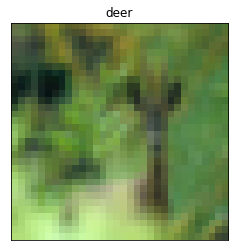

In [ ]:
# Code here!
# display one random image from the training set:
class_names =  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

idx = np.random.randint(0, X_train0.shape[0])
print(idx)
image = X_train0[idx]
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[y_train0[idx][0]])
plt.xticks([])
plt.yticks([])
plt.show()

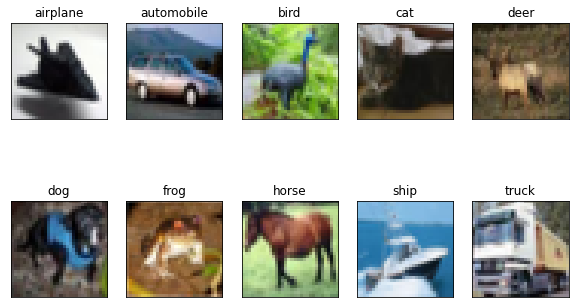

In [ ]:
fig = plt.figure(figsize=(10,6))
num0_9 = np.unique(y_train0, return_index=True)[1]
images = X_train[num0_9]
for i in range(10):
    plt.subplot(2, 5, i+1)
    # num0_9 = X_train0[y_train0 == i]
    
    # print(num0_9.shape)
    # plt.imshow(num0_9[0]) 
    plt.imshow(images[i])
    plt.title(class_names[i])
    plt.xticks([])
    plt.yticks([])

# Design CNN

### import models, layers, callbacks
- models: Sequential
- layers: Conv2D, MaxPool2D, Flatten
- callbacks: ModelCheckpoint, EarlyStopping

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers

In [ ]:
# 모델 구성
num_classes = 10
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# data augmentation
# https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(X_train)

(9, 32, 32, 3) (9, 10)


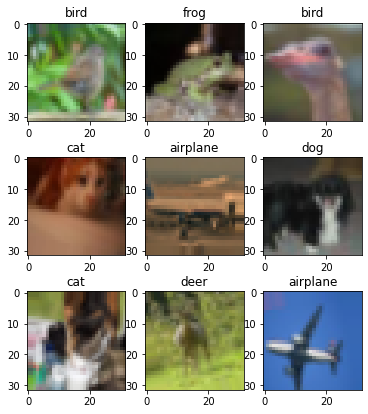

In [ ]:
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    print(X_batch.shape, y_batch.shape)
    # create a grid of 3x3 images
    plt.figure(figsize=(6,7))
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i]) #, cmap=plt.get_cmap('gray'))
        plt.title(class_names[np.argmax(y_batch[i])])
        # show the plot
    plt.show()
    break


In [ ]:
BATCH_SIZE=50
itr = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
itr.next()[0].shape,itr.next()[1].shape

((50, 32, 32, 3), (50, 10))

In [ ]:
# itr.next()[0][0].shape

In [ ]:
images = itr.next()[0] #np.squeeze(itr.next()[0],3)
images.shape

(50, 32, 32, 3)

In [ ]:
labels = np.argmax(itr.next()[1],1)
labels

array([7, 0, 2, 0, 0, 6, 4, 8, 3, 3, 0, 1, 9, 7, 2, 1, 9, 7, 0, 9, 9, 7,
       2, 7, 7, 7, 4, 9, 7, 6, 0, 7, 5, 3, 7, 7, 2, 2, 6, 0, 3, 4, 2, 3,
       6, 1, 7, 0, 1, 7], dtype=int64)

(50, 32, 32, 3) (50, 10)


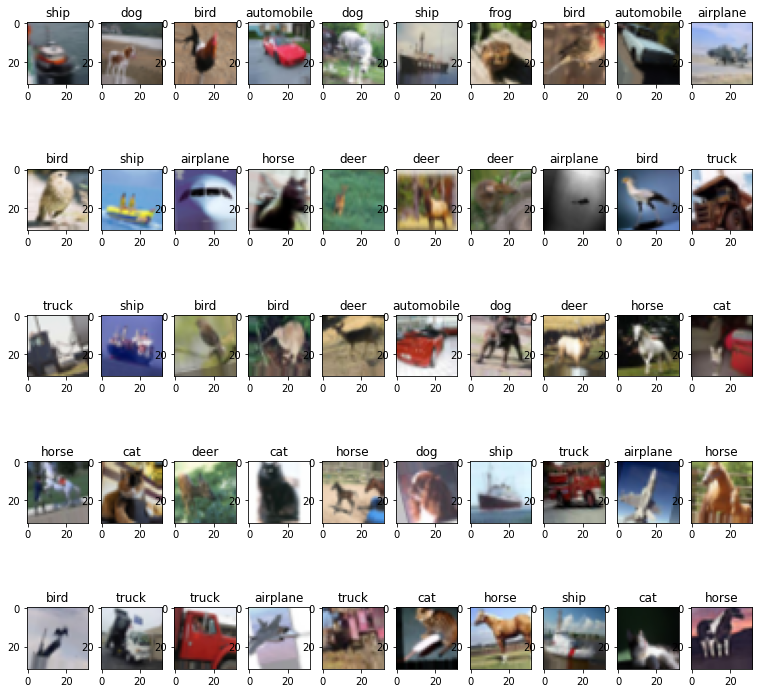

In [ ]:
BATCH_SIZE = 50
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=BATCH_SIZE):
    print(X_batch.shape, y_batch.shape)
    # create a grid of 5x10 images
    plt.figure(figsize=(13,13))
    for i in range(BATCH_SIZE):
        plt.subplot(5,10,i+1)
        plt.imshow(X_batch[i]) #, cmap=plt.get_cmap('gray'))
        plt.title(class_names[np.argmax(y_batch[i])])
        # show the plot
    plt.show()
    break


### wrong match between images and classes by iteration

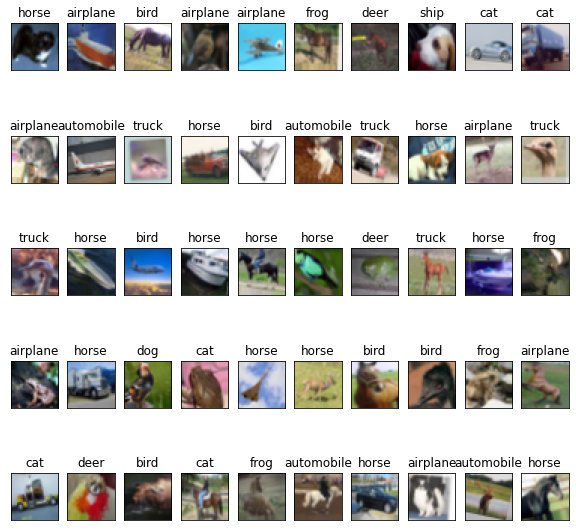

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(BATCH_SIZE):
    plt.subplot(5, 10, i+1)
    # num0_9 = X_train0[y_train0 == i]
    # print(num0_9.shape)
    plt.imshow(images[i]) #, cmap='gray') 
    plt.title(class_names[labels[i]])
    plt.xticks([])
    plt.yticks([])

In [ ]:
opt_rms = keras.optimizers.RMSprop(learning_rate=0.001,decay=1e-6)

In [ ]:
cp_callback = callbacks.ModelCheckpoint(filepath="./cifar10_Daug_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [ ]:
model.compile(loss='categorical_crossentropy',
        optimizer='adam', #opt_rms,
        metrics=['accuracy'])

In [ ]:
epochs = 500
hist = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                 steps_per_epoch=X_train.shape[0]//BATCH_SIZE, 
                 epochs=epochs, verbose=1, 
                 callbacks=[cp_callback, es_callback], 
                 validation_data=(X_test,y_test))

Epoch 1/500
1000/1000 [==============================] - 22s 19ms/step - loss: 1.5841 - accuracy: 0.4501 - val_loss: 1.2257 - val_accuracy: 0.5738
Epoch 2/500
1000/1000 [==============================] - 19s 19ms/step - loss: 1.1886 - accuracy: 0.5939 - val_loss: 1.3135 - val_accuracy: 0.5700
Epoch 3/500
1000/1000 [==============================] - 20s 20ms/step - loss: 1.0300 - accuracy: 0.6594 - val_loss: 1.0128 - val_accuracy: 0.6728
Epoch 4/500
1000/1000 [==============================] - 19s 19ms/step - loss: 0.9510 - accuracy: 0.6927 - val_loss: 1.1277 - val_accuracy: 0.6548
Epoch 5/500
1000/1000 [==============================] - 19s 19ms/step - loss: 0.9076 - accuracy: 0.7130 - val_loss: 1.0360 - val_accuracy: 0.6868
Epoch 6/500
1000/1000 [==============================] - 19s 19ms/step - loss: 0.8583 - accuracy: 0.7369 - val_loss: 0.8864 - val_accuracy: 0.7363
Epoch 7/500
1000/1000 [==============================] - 19s 19ms/step - loss: 0.8398 - accuracy: 0.7456 - val_loss: 0

In [ ]:
model.evaluate(X_test, y_test, batch_size = BATCH_SIZE)

200/200 [==============================] - 1s 5ms/step - loss: 0.6642 - accuracy: 0.8334


[0.664156436920166, 0.8334000110626221]

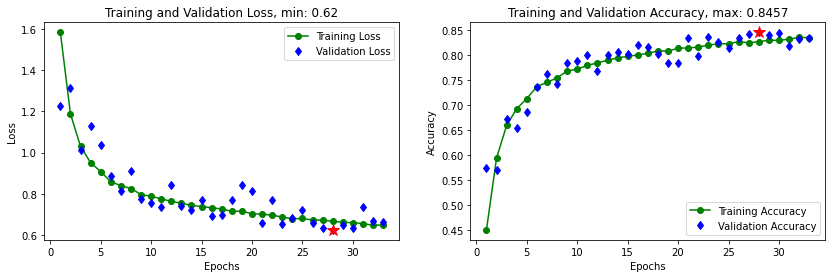

In [ ]:
# More graphs of loss and accuracy
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],2)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

---

## **CNN2 + FCN2**

In [ ]:
c2f2 = keras.models.Sequential([ 
    Conv2D(input_shape=(32,32,3),kernel_size=(3,3),strides=(1,1),filters= 32,padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 64,padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c2f2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [ ]:
c2f2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
cp_callback = callbacks.ModelCheckpoint(filepath="./cifar10_c2f2_Daug_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)    # patience=10,20,50

In [ ]:
# hist = c2f2.fit(X_train, y_train, epochs = 500 , batch_size =32, 
#          callbacks=[cp_callback, es_callback], 
#          validation_data=(X_test,y_test))

epochs = 500
hist = c2f2.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), # BATCH_SIZE = 50
                 steps_per_epoch=X_train.shape[0]//BATCH_SIZE, 
                 epochs=epochs, verbose=1, 
                 callbacks=[cp_callback, es_callback], 
                 validation_data=(X_test,y_test))    

Epoch 1/500
1000/1000 [==============================] - 19s 19ms/step - loss: 1.6207 - accuracy: 0.4084 - val_loss: 1.3017 - val_accuracy: 0.5380
Epoch 2/500
1000/1000 [==============================] - 18s 18ms/step - loss: 1.3318 - accuracy: 0.5230 - val_loss: 1.1562 - val_accuracy: 0.5923
Epoch 3/500
1000/1000 [==============================] - 18s 18ms/step - loss: 1.2330 - accuracy: 0.5581 - val_loss: 1.0621 - val_accuracy: 0.6263
Epoch 4/500
1000/1000 [==============================] - 18s 18ms/step - loss: 1.1689 - accuracy: 0.5822 - val_loss: 1.0443 - val_accuracy: 0.6198
Epoch 5/500
1000/1000 [==============================] - 18s 18ms/step - loss: 1.1287 - accuracy: 0.5989 - val_loss: 0.9915 - val_accuracy: 0.6491
Epoch 6/500
1000/1000 [==============================] - 19s 19ms/step - loss: 1.0911 - accuracy: 0.6114 - val_loss: 0.9728 - val_accuracy: 0.6648
Epoch 7/500
1000/1000 [==============================] - 17s 17ms/step - loss: 1.0603 - accuracy: 0.6252 - val_loss: 0

In [ ]:
c2f2.evaluate(X_test, y_test, batch_size = BATCH_SIZE)

200/200 [==============================] - 1s 3ms/step - loss: 0.8091 - accuracy: 0.7270


[0.8091124296188354, 0.7269999980926514]

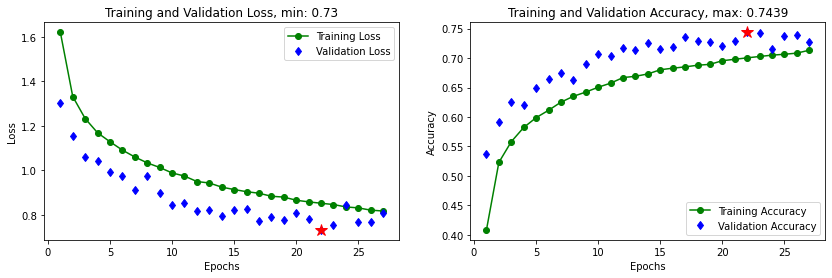

In [ ]:
# More graphs of loss and accuracy
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],2)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 모형의 저장

- 트레이닝이 끝난 모형은 save 메서드로 가중치와 함께 hdf5 형식으로 저장
- load 명령으로 불러 사용

In [ ]:
# c2f2.save('cnn_best.hdf5')

In [ ]:
from keras.models import load_model

model_c2f2_best = load_model('model/cifar10_c2f2_Daug_best_weights.028-0.9231.hdf5')
model_c2f2_best.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

200/200 [==============================] - 1s 3ms/step - loss: 0.2231 - accuracy: 0.9231


[0.22314901649951935, 0.9230999946594238]

---

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model_c2f2_best.predict(X_test)
predictions0 = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test0, predictions0)


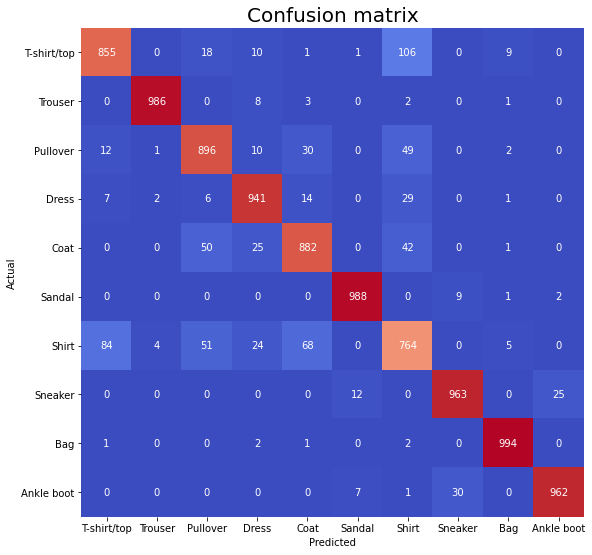

In [ ]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix', fontsize=20)
plt.show()

---